In [1]:
import sys
import torch
import numpy as np
import random
import os
import time
import pdb
from models import create_Inet
import torch
import torchvision
import torchvision.transforms as transforms
from scipy import interpolate
from utils.image_folder import ImageFolder
from utils import utils
from utils.utils import *
# from utils.Visualizer import Visualizer
import matplotlib.pyplot as plt
from IPython.display import clear_output
from options import DefaultConfig
opt = DefaultConfig()
torch.cuda.set_device(opt.gpu_ids)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)
torch.backends.cudnn.deterministic = True

Interaction Network: initialized


In [2]:
#opt.dataroot_train = '/home/zhangy23/dataset/flickr30k/train/'
opt.dataroot_train = opt.dataroot + 'train/'
dataset_train = ImageFolder(opt.dataroot_train,
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.RandomResizedCrop(opt.fineSize),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()]))
dataset_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=opt.batch_size, shuffle=True)
dataset_train_size = len(dataset_train)
print('#training images = %d' % dataset_train_size)

opt.dataroot_val = opt.dataroot + 'subval/'
dataset_val = ImageFolder(opt.dataroot_val,
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.RandomResizedCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=opt.batch_size_val, shuffle=True)
dataset_val_size = len(dataset_val)
print('#training images = %d' % dataset_val_size)

#training images = 118060
#training images = 1000


In [3]:
model = create_Inet(opt)
model.setup(opt)
# print(model)
if opt.gpu_ids is not None:
    model.cuda()

Interaction net was created


In [4]:
!nvidia-smi 

Tue Apr  7 03:38:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:19:00.0 Off |                  N/A |
| 38%   72C    P2   122W / 250W |   5530MiB / 11019MiB |     45%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 27%   59C    P2    57W / 250W |    906MiB / 11019MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2020-04-07 03:38:15


Code optimisation:
1. rewrite sampling code using numpy
2. rewrite network structure and make it compataple for non-click input
3. rewrite validation code 

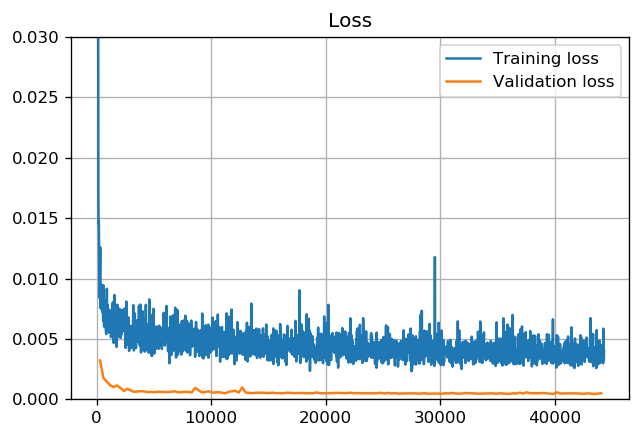

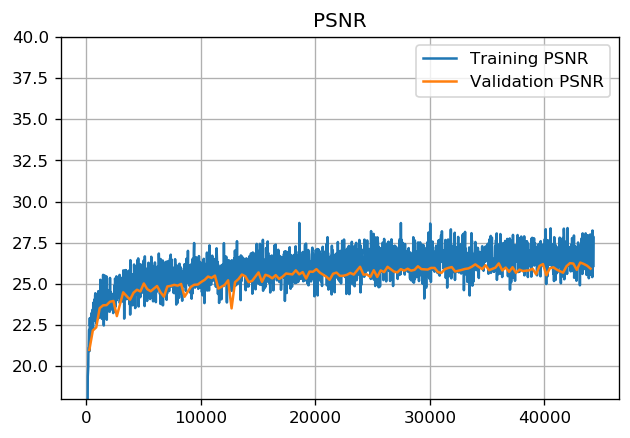

In [6]:
X_val = []
X_train = []

val_losses = []
train_losses = []
val_psnrs = []
train_psnrs = []

total_steps = 0
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay):
    val_step = 0
    model_index = 0
    for i, data_raw in enumerate(dataset_loader_train):
        total_steps += 1
        val_step += 1
        
        data_np = utils.get_colorization_data(data_raw, opt, p=opt.sample_p)
        if(data_np is None):
            continue
        data = ToCuda(data_np)
        fake_ab = model(data['gray'], data['clicks'], data['prev'])
        loss = model.calc_loss(data['ab'], fake_ab)
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        
        if val_step % opt.val_freq == 0:
            print('validation phase')
            val_loss = 0
            val_psnr = 0

            model.eval()
            for ii, data_raw_val in enumerate(dataset_loader_val):
                data_np_val = utils.get_colorization_data(data_raw_val, opt, p=opt.sample_p)
                if(data_np_val is None):
                    continue
                data_val = ToCuda(data_np_val)
                fake_ab_val = model(data_val['gray'], data_val['clicks'], data_val['prev'])
                loss_val = model.calc_loss(data_val['ab'], fake_ab_val)
                
                psnr_val = calc_batch_psnr(data_val['gray'].detach(), data_val['ab'].detach(), fake_ab_val.detach(), opt, avg=False)

                val_loss += loss_val.detach().cpu().numpy()
                val_psnr += psnr_val
            val_psnrs.append(val_psnr / dataset_val_size)
            val_losses.append(val_loss / dataset_val_size)
            X_val.append(total_steps)
            model.train()
            
            # save model
            model_index += 1
            save_model(model, opt, epoch, model_index, val_psnr / dataset_val_size)

        if total_steps % opt.print_freq == 0:
            X_train.append(total_steps)
            # loss and PSNR
            train_psnrs.append(calc_batch_psnr(data['gray'].detach(), data['ab'].detach(), fake_ab.detach(), opt))
            train_losses.append(loss.detach().cpu().numpy())
            
            # plot loss and PSNR curve
            clear_output(wait=True)
            plt.figure(1)
            plt.rcParams['figure.dpi'] = 120 
            plt.ylim([0, .03])
            plt.title('Loss')
            plt.plot(X_train, train_losses, label="Training loss")
            plt.plot(X_val, val_losses, label="Validation loss")
            plt.grid(True)
            plt.legend()
            plt.show()

            plt.figure(2)
            plt.rcParams['figure.dpi'] = 120 
            plt.ylim([18, 40])
            plt.title('PSNR')
            plt.plot(X_train, train_psnrs, label="Training PSNR")
            plt.plot(X_val, val_psnrs, label="Validation PSNR")
            plt.grid(True)
            plt.legend()
            plt.show()

    np.save('Iter'+str(epoch)+'train_loss.npy', train_losses)
    np.save('Iter'+str(epoch)+'val_loss.npy', val_losses)
    np.save('Iter'+str(epoch)+'train_psnr.npy', train_psnrs)
    np.save('Iter'+str(epoch)+'val_psnrs.npy', val_psnrs)


In [ ]:
#!sudo apt-get install -y psmisc
#!fuser /dev/nvidia*

In [ ]:
#!kill 1529